# Генерация данных по резервам

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn import metrics
import catboost

%matplotlib inline

In [21]:
data = {
    'air_reserve': pd.read_csv('dataset/air_reserve.csv'),
    'hpg_reserve': pd.read_csv('dataset/hpg_reserve.csv'),
    'air_hpg':     pd.read_csv('dataset/store_id_relation.csv'),
    'cities':      pd.read_csv('dataset/cities.csv'),
    
    'air_stores': pd.read_csv('result/air_stores.csv'),
    'hpg_stores': pd.read_csv('result/hpg_stores.csv'),
    'dates':      pd.read_csv('result/dates.csv'),
}

### Подготавливаем `air_reserve` и `hpg_reserve`

 Расширяем `air_reserve` данными из `hpg_reserve`

In [22]:
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['air_hpg'], how='left', on=['hpg_store_id'])
data['air_reserve'] = pd.concat([data['air_reserve'], data['hpg_reserve'].drop('hpg_store_id', axis=1).dropna()])

Удаляем дублирующие `air_reserve` записи из `hpg_reserve`

In [23]:
data['hpg_reserve'] = data['hpg_reserve'][data['hpg_reserve'].isnull()['air_store_id']].drop('air_store_id', axis=1)

In [24]:
print('air_reserve', data['air_reserve'].shape)
print('hpg_reserve', data['hpg_reserve'].shape)

air_reserve (120561, 4)
hpg_reserve (1972137, 4)


### Формируем `reserve_all`

 Объединяем `air_reserve` и `hpg_reserve`

In [25]:
data['air_reserve'] = pd.merge(data['air_reserve'], data['air_stores'], how='inner', on=['air_store_id'])
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['hpg_stores'], how='inner', on=['hpg_store_id'])

columns = ['visit_datetime', 'reserve_visitors', 'city']
data['reserve_all'] = pd.concat([data['air_reserve'][columns], data['air_reserve'][columns]])

In [26]:
print('reserve_all', data['reserve_all'].shape)

data['reserve_all'].head()

reserve_all (241122, 3)


,visit_datetime,reserve_visitors,city
0,2016-01-01 19:00:00,1,Tokyo
1,2016-01-01 20:00:00,2,Tokyo
2,2016-01-02 18:00:00,2,Tokyo
3,2016-01-02 21:00:00,2,Tokyo
4,2016-01-08 21:00:00,2,Tokyo


Объединяем записи в `reserve_all`

In [27]:
data['reserve_all']['visit_datetime'] = pd.to_datetime(data['reserve_all']['visit_datetime'])
data['reserve_all']['visit_date']     = data['reserve_all']['visit_datetime'].dt.strftime('%Y-%m-%d')

data['reserve_all'] = data['reserve_all'].groupby(['visit_date', 'city'], as_index=False)[['reserve_visitors']].sum()
data['reserve_all'] = data['reserve_all'].rename(columns={'reserve_visitors': 'reserve_visitors_all'})

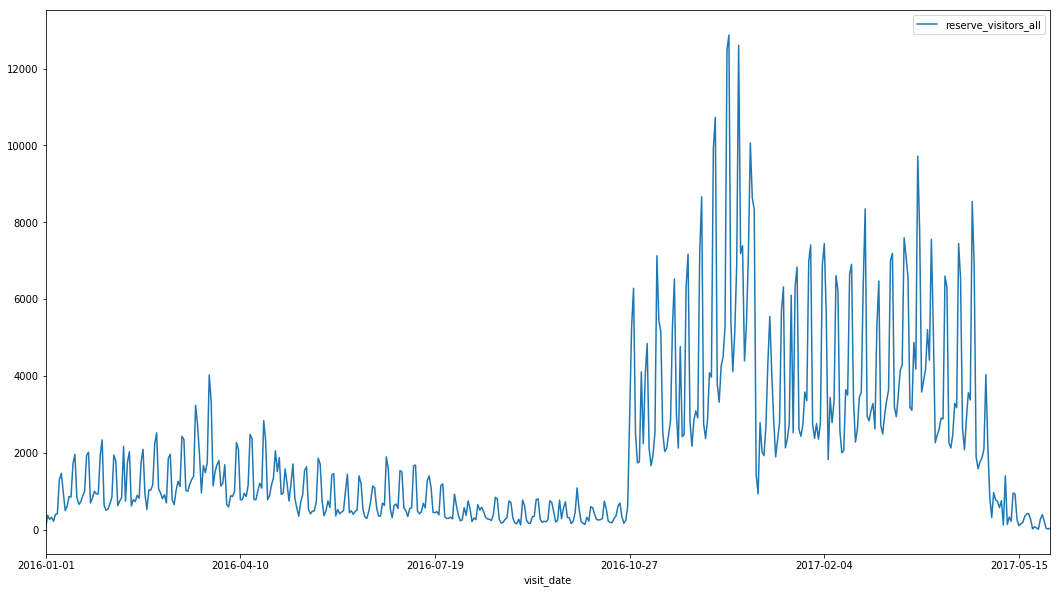

In [28]:
data['reserve_all'].groupby(['visit_date'])[['reserve_visitors_all']].sum().plot(figsize=(18,10))
pyplot.show()

### Обрабатываем список ресторанов и дат

In [29]:
stores_id = data['air_stores']['air_store_id']
data['stores_dates'] = pd.concat(
    [pd.DataFrame({
        'air_store_id': stores_id,
        'visit_date':   [visit_date] * len(stores_id),
    }) for visit_date in data['dates']['visit_date']],
    axis=0,
    ignore_index=True,
).reset_index(drop=True)

In [30]:
data['stores_dates'] = pd.merge(data['stores_dates'], data['air_stores'], how='left', on=['air_store_id'])

In [31]:
print('stores_dates', data['stores_dates'].shape)

data['stores_dates'].head()

stores_dates (428593, 7)


,air_store_id,visit_date,air_genre_name,air_area_name,latitude,longitude,city
0,air_0f0cdeee6c9bf3d7,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka
1,air_7cc17a324ae5c7dc,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka
2,air_fee8dcf4d619598e,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka
3,air_a17f0778617c76e2,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka
4,air_83db5aff8f50478e,2016-01-01,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo


### Формируем `reserve`

In [32]:
columns = ['air_store_id', 'visit_datetime', 'reserve_visitors', 'city']
data['reserve'] = data['air_reserve'][columns].copy()

In [33]:
print('reserve', data['reserve'].shape)

data['reserve'].head()

reserve (120561, 4)


,air_store_id,visit_datetime,reserve_visitors,city
0,air_877f79706adbfb06,2016-01-01 19:00:00,1,Tokyo
1,air_877f79706adbfb06,2016-01-01 20:00:00,2,Tokyo
2,air_877f79706adbfb06,2016-01-02 18:00:00,2,Tokyo
3,air_877f79706adbfb06,2016-01-02 21:00:00,2,Tokyo
4,air_877f79706adbfb06,2016-01-08 21:00:00,2,Tokyo


Объединяем записи в `reserve`

In [34]:
data['reserve']['visit_datetime'] = pd.to_datetime(data['reserve']['visit_datetime'])
data['reserve']['visit_date']     = data['reserve']['visit_datetime'].dt.strftime('%Y-%m-%d')

data['reserve'] = data['reserve'].groupby(['air_store_id', 'visit_date'], as_index=False)[['reserve_visitors']].sum()

In [35]:
data['reserve'] = pd.merge(data['stores_dates'], data['reserve'], how='left', on=['air_store_id', 'visit_date'])
data['reserve'] = data['reserve'].fillna(0)

data['reserve']['reserve_visitors'] = data['reserve']['reserve_visitors'].astype(int)

In [36]:
print('air_reserve', data['air_reserve'].shape)
print('reserve    ', data['reserve'].shape)

air_reserve (120561, 9)
reserve     (428593, 8)


In [37]:
print('reserve', data['reserve'].shape)

data['reserve'].head()

reserve (428593, 8)


,air_store_id,visit_date,air_genre_name,air_area_name,latitude,longitude,city,reserve_visitors
0,air_0f0cdeee6c9bf3d7,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,0
1,air_7cc17a324ae5c7dc,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,0
2,air_fee8dcf4d619598e,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,0
3,air_a17f0778617c76e2,2016-01-01,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,0
4,air_83db5aff8f50478e,2016-01-01,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,0


Добвляем информацию о резервах в других ресторанах

In [38]:
data['reserve'] = pd.merge(data['reserve'], data['reserve_all'], how='left', on=['visit_date', 'city'])

data['reserve']['reserve_visitors_competitor'] = data['reserve']['reserve_visitors_all'] - data['reserve']['reserve_visitors']

columns = ['air_store_id', 'visit_date', 'reserve_visitors', 'reserve_visitors_competitor']
data['reserve'] = data['reserve'][columns]

data['reserve'] = data['reserve'].fillna(0)

In [39]:
print('reserve', data['reserve'].shape)

data['reserve'].head()

reserve (428593, 4)


,air_store_id,visit_date,reserve_visitors,reserve_visitors_competitor
0,air_0f0cdeee6c9bf3d7,2016-01-01,0,22.0
1,air_7cc17a324ae5c7dc,2016-01-01,0,22.0
2,air_fee8dcf4d619598e,2016-01-01,0,22.0
3,air_a17f0778617c76e2,2016-01-01,0,22.0
4,air_83db5aff8f50478e,2016-01-01,0,6.0


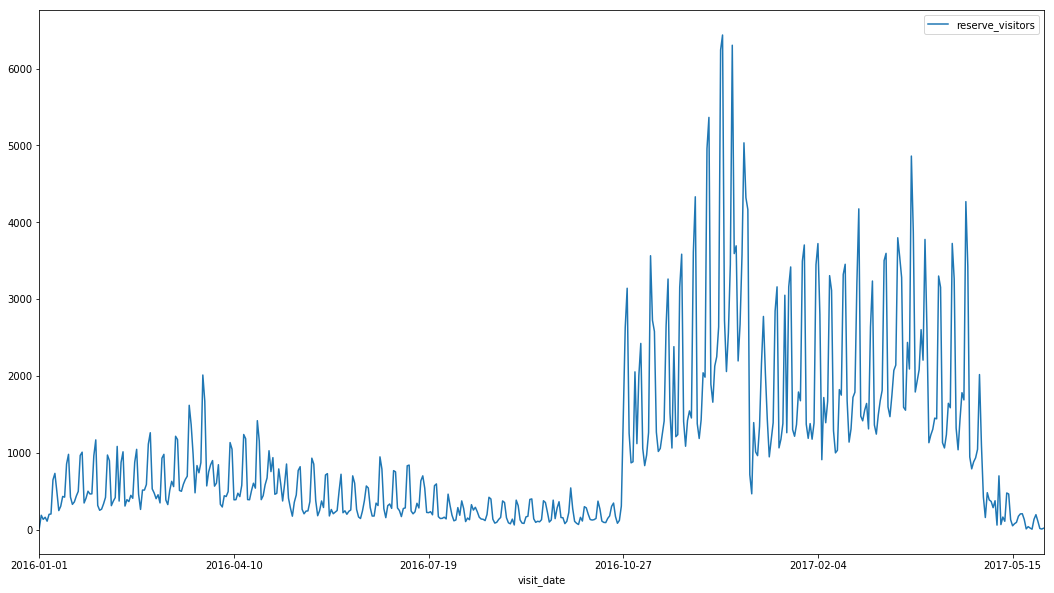

In [40]:
data['reserve'].groupby(['visit_date'])[['reserve_visitors']].sum().plot(figsize=(18,10))
pyplot.show()

In [41]:
data['reserve'].to_csv('result/reserve.csv', index=False)